## <center> Road Traffic Prediction : EDA, Prophet, SARIMA and SARIMAX </center>
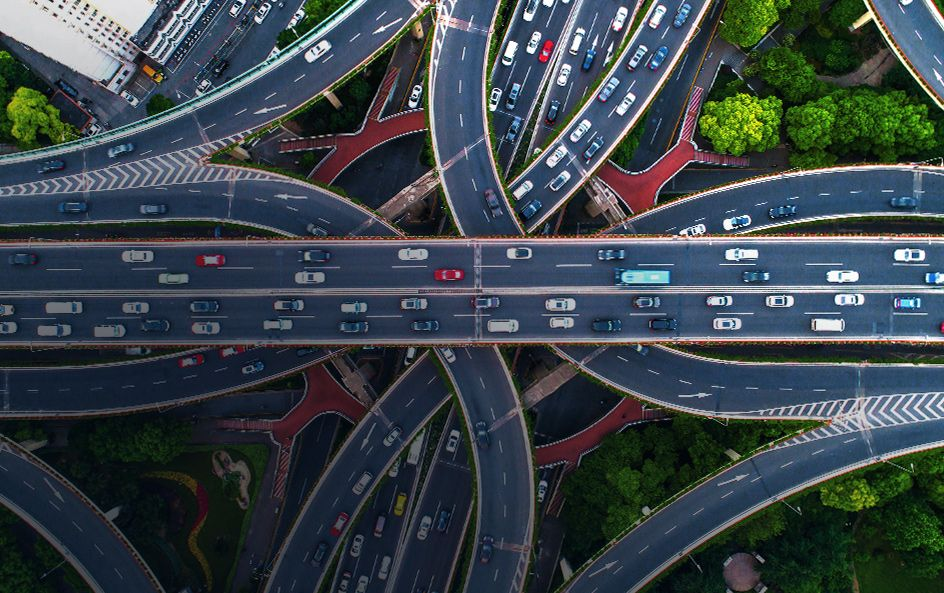

#### Context
Traffic congestion is increasing in cities worldwide, driven by growing urban populations, outdated infrastructure, poorly coordinated traffic signals, and a lack of real-time data. The consequences are substantial. According to traffic data and analytics firm INRIX, U.S. commuters lost $305 billion in 2017 due to wasted fuel, lost time, and higher costs of transporting goods through congested areas. With limited physical space and financial resources to build more roads, cities need to adopt new strategies and technologies to enhance traffic management.
</br></br>
#### Content
This dataset contains 48.1k (48120) observations of the number of vehicles each hour in four different junctions. In this project, we'll focus solely on data from Junction 1.

In [58]:
# !pip install prophet
# !pip install holidays

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.api.types import CategoricalDtype
import holidays
from sklearn.linear_model import LinearRegression
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

## Import time series data

In [60]:
df = pd.read_csv('traffic.csv',index_col=[0],parse_dates=[0])
df.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [61]:
df.shape

(48120, 3)

## Pre-processing

In [62]:
df = df[df['Junction'] == 1]             # Filter for Junction 1 
df = df.drop(columns=['ID', 'Junction']) # Drop the 'ID' and 'Junction' columns
df.head()

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9


In [63]:
df.shape

(14592, 1)

In [64]:
# check for missing values and fill them if there
if(df.isnull().sum().sum()==0):
    print('No missing values.')
else:
    df.fillna(method='ffill',inplace=True)

No missing values.


## Feature engineering

In [65]:
cat_type = CategoricalDtype(categories=['Monday','Tuesday','Wednesday',
                                        'Thursday','Friday','Saturday','Sunday'],
                            ordered=True)
us_holidays = holidays.US(years=[2015, 2016, 2017])

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['isholiday'] = df['date'].dt.normalize().isin(us_holidays)
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','isholiday','weekday','month','year','season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='Vehicles')
features_and_target = pd.concat([X, y], axis=1)

# Display the first few rows to verify
print(features_and_target[features_and_target['isholiday'] == True])

                     hour  isholiday    weekday  month  year  season  Vehicles
DateTime                                                                      
2015-11-11 00:00:00     0       True  Wednesday     11  2015    Fall        28
2015-11-11 01:00:00     1       True  Wednesday     11  2015    Fall        25
2015-11-11 02:00:00     2       True  Wednesday     11  2015    Fall        19
2015-11-11 03:00:00     3       True  Wednesday     11  2015    Fall        21
2015-11-11 04:00:00     4       True  Wednesday     11  2015    Fall        20
...                   ...        ...        ...    ...   ...     ...       ...
2017-05-29 19:00:00    19       True     Monday      5  2017  Spring       104
2017-05-29 20:00:00    20       True     Monday      5  2017  Spring        93
2017-05-29 21:00:00    21       True     Monday      5  2017  Spring        84
2017-05-29 22:00:00    22       True     Monday      5  2017  Spring        89
2017-05-29 23:00:00    23       True     Monday     

## Data Visualization

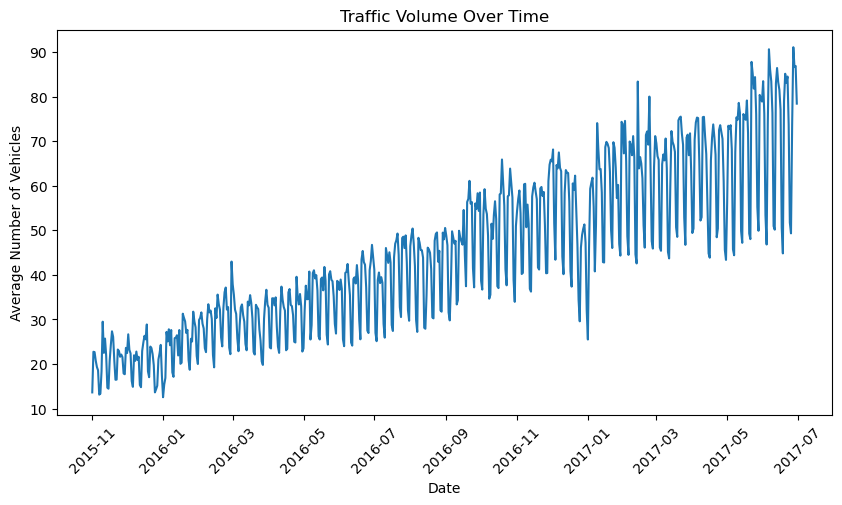

In [66]:
# For better readability, resample the data by day and take the mean
plt.figure(figsize=(10, 5))
df_daily = df.resample('D').mean()
plt.plot(df_daily.index, df_daily['Vehicles'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Average Number of Vehicles')
plt.show()

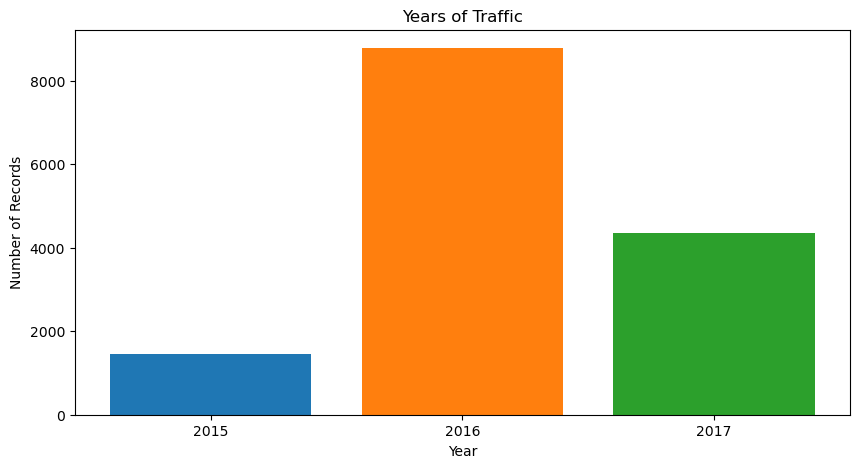

In [67]:
# Years of traffic
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
year_counts = features_and_target['year'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(year_counts.index.astype(str), year_counts.values, color=colors[:len(year_counts)])
plt.title("Years of Traffic")
plt.xlabel("Year")
plt.ylabel("Number of Records")
plt.show()

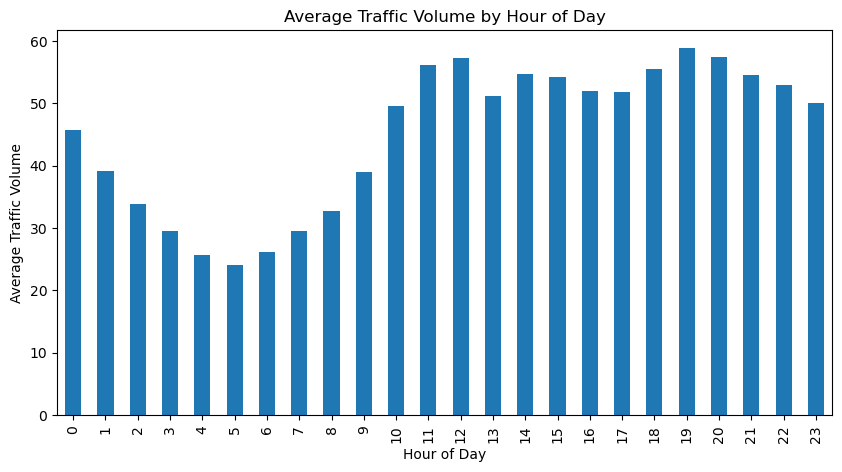

In [68]:
# Peak Hours Identification
plt.figure(figsize=(10, 5))
avg_traffic_by_hour = features_and_target.groupby('hour')['Vehicles'].mean()
avg_traffic_by_hour.plot(kind='bar')
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.show()

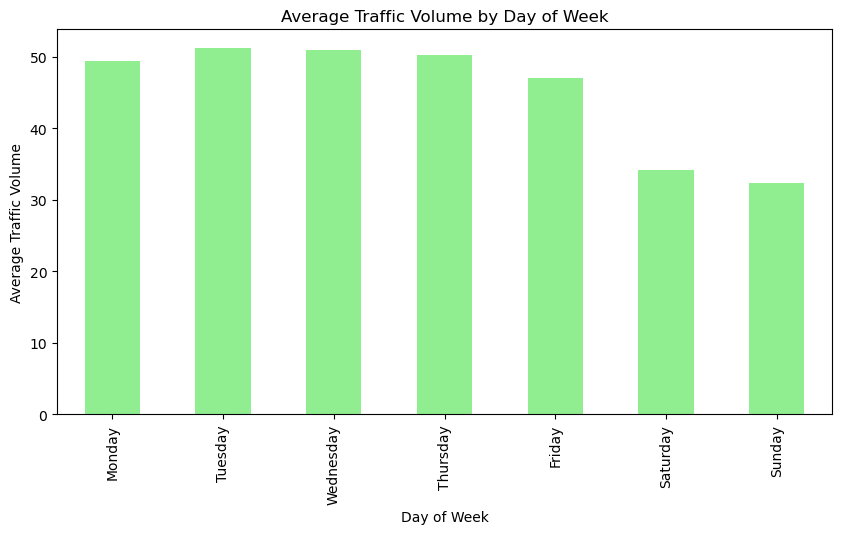

In [69]:
# Determine how traffic volumes vary by day of the week
plt.figure(figsize=(10, 5))
average_traffic_by_day = features_and_target.groupby('weekday')['Vehicles'].mean()
average_traffic_by_day.plot(kind='bar', color='lightgreen')
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.show()

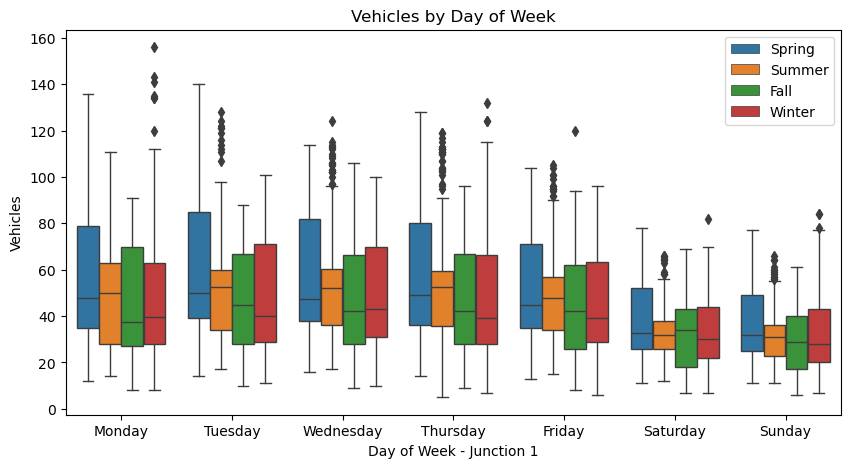

In [70]:
# Determine how traffic volumes differ vary by Day of Week and Season
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Vehicles',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Vehicles by Day of Week')
ax.set_xlabel('Day of Week - Junction 1')
ax.set_ylabel('Vehicles')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

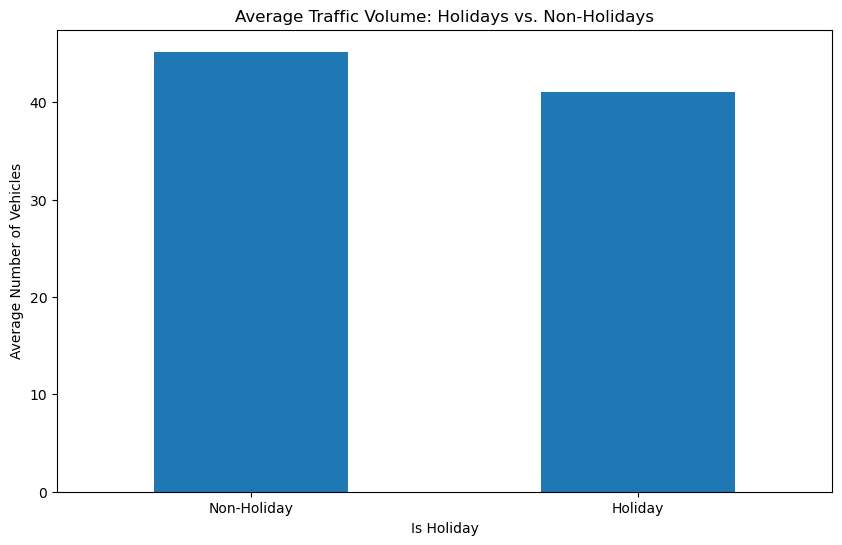

In [71]:
# Assess how public holidays and other significant days affect traffic volumes
average_volume = features_and_target.groupby('isholiday')['Vehicles'].mean()
plt.figure(figsize=(10, 6))
average_volume.plot(kind='bar')
plt.title('Average Traffic Volume: Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Average Number of Vehicles')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

## Time Series Decomposition

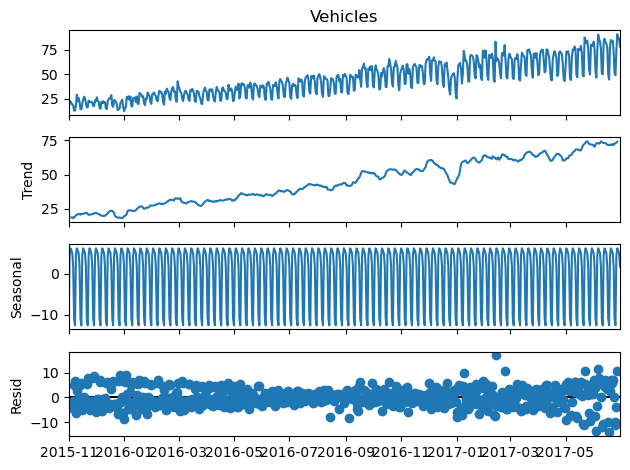

In [72]:
# Perform the seasonal decomposition
result = seasonal_decompose(df_daily['Vehicles'], model='additive', period=7)
result.plot()
plt.tight_layout()
plt.show()

- The traffic volume data shows a repeating pattern, indicating seasonality, likely weekly.
- **The trend component** suggests periods of increase and decrease in traffic, though specific conclusions require more context. 
- **The seasonal component** reveals consistent peaks and troughs, likely tied to workweek patterns. 
- **Residuals**, representing irregularities, are mostly random with a few outliers, indicating that the model effectively captures trend and seasonality. 
</br></br>

Overall, the analysis highlights a strong seasonal pattern, useful for both long-term planning and short-term traffic management.

## Long-term Trends
Analyze if there is a long-term increase or decrease in traffic volumes, which could be indicative of urban development or changes in population density

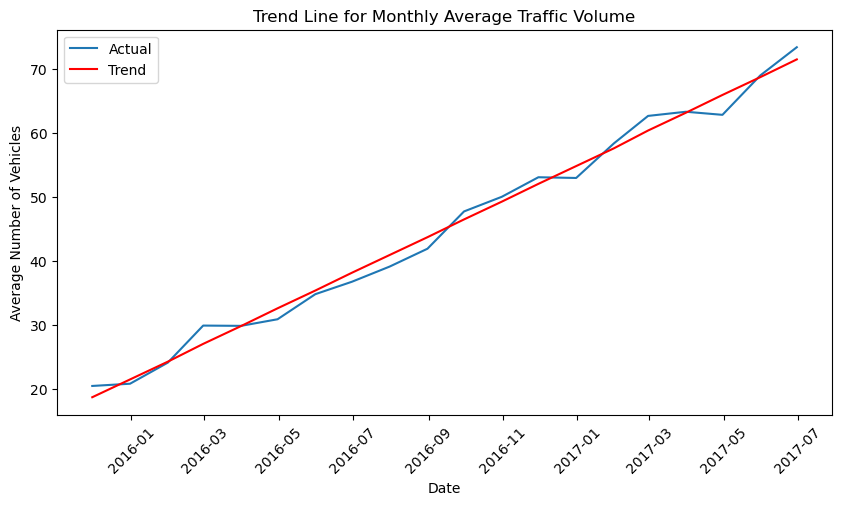

In [73]:
# Resample the data to get monthly averages
df_monthly = df.resample('M').mean()

# Linear Regression for Trend Analysis
X = np.arange(len(df_monthly)).reshape(-1, 1)  # Time as an independent variable
y = df_monthly['Vehicles'].values  # Traffic volume as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the trend
plt.figure(figsize=(10, 5))
plt.plot(df_monthly.index, y, label='Actual')
plt.plot(df_monthly.index, trend, label='Trend', color='red')
plt.title('Trend Line for Monthly Average Traffic Volume')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Average Number of Vehicles')
plt.legend()
plt.show()

The linear trend line highlights a **long-term upward trend** in traffic volumes, likely driven by urban development, population growth, and changing traffic patterns, underscoring the need for improved infrastructure and transportation planning.
</br></br>

This rising trend highlights the importance of adapting traffic management strategies and provides valuable insights for city planners and policymakers to consider infrastructure improvements and public transportation enhancements to alleviate potential congestion.

## Impact of External Factors
Detect and visualize significant deviations (anomalies) in daily traffic volume - like nearby construction projects or new traffic regulations - by calculating the Z-score and setting a threshold.

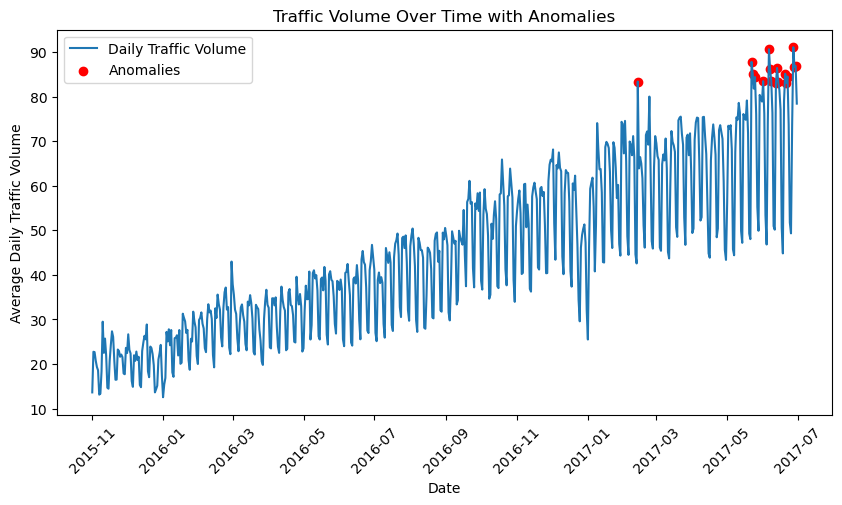

In [74]:
# Calculate the Z-score for each day's traffic volume
df_daily['z_score'] = (df_daily['Vehicles'] - df_daily['Vehicles'].mean()) / df_daily['Vehicles'].std()

# Identify days where the Z-score is above a certain threshold (e.g., 2 or -2 for significant anomalies)
anomalies = df_daily[abs(df_daily['z_score']) > 2]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_daily.index, df_daily['Vehicles'], label='Daily Traffic Volume')
plt.scatter(anomalies.index, anomalies['Vehicles'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Average Daily Traffic Volume')
plt.title('Traffic Volume Over Time with Anomalies')
plt.legend()
plt.show()

- Anomalies : The red dots represent days that have been identified as anomalies, where the traffic volume was significantly different from the norm. These could be days with exceptionally high traffic volume compared to the average on other day
- Potential External Factors : The anomalies could be due to external factors such as road closures, construction projects, accidents, events, or changes in traffic regulations. These would need to be investigated by cross-referencing the dates of the anomalies with external event data.

## Train / Test Split

In [75]:
df_daily = df.resample('D').mean()
split_date = '1-Jan-2017'
df_train = df_daily.loc[df_daily.index <= split_date].copy()
df_test = df_daily.loc[df_daily.index > split_date].copy()

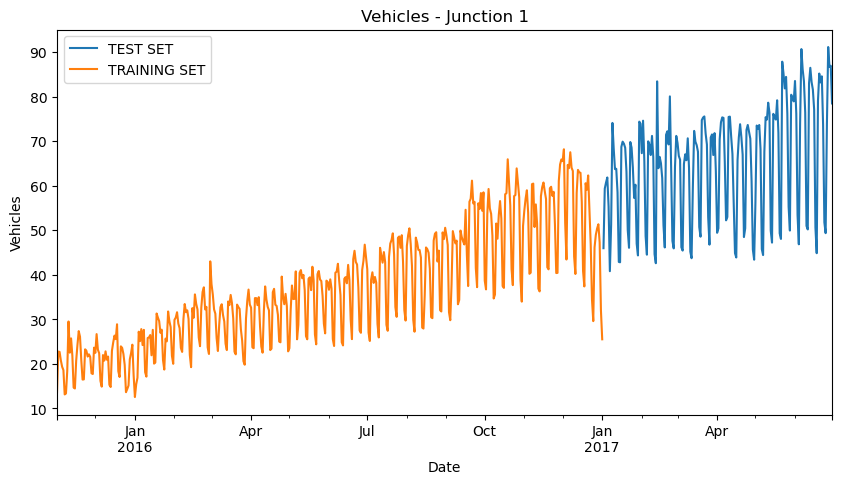

In [76]:
# Plot train and test so we can see where we have split
df_test \
    .rename(columns={'Vehicles': 'TEST SET'}) \
    .join(df_train.rename(columns={'Vehicles': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Vehicles - Junction 1', style='-', ms=1)
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.show()

## Prophet Model

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
- Datetime column named: ds
- target : y

In [77]:
df_train.head()

,Vehicles
DateTime,
2015-11-01,13.625000
2015-11-02,22.750000
2015-11-03,22.666667
2015-11-04,20.750000
2015-11-05,19.333333


In [78]:
# Format data for prophet model using ds and y
# Resetting the index converts the datetime index into a regular column
df_train_prophet = df_train.reset_index().rename(columns={'DateTime': 'ds', 'Vehicles': 'y'})
df_train_prophet.head()

,ds,y
0,2015-11-01,13.625000
1,2015-11-02,22.750000
2,2015-11-03,22.666667
3,2015-11-04,20.750000
4,2015-11-05,19.333333


##### Fit

In [79]:
%%time
model = Prophet()
model.fit(df_train_prophet)

13:17:14 - cmdstanpy - INFO - Chain [1] start processing
13:17:14 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 31.2 ms
Wall time: 246 ms


##### Predictions

In [80]:
df_test_prophet = df_test.reset_index() \
    .rename(columns={'DateTime':'ds',
                     'Vehicles':'y'})
df_test_fcst = model.predict(df_test_prophet)
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02,54.748529,53.381602,63.481878,54.748529,54.748529,3.653349,3.653349,3.653349,3.653349,3.653349,3.653349,0.0,0.0,0.0,58.401878
1,2017-01-03,54.817776,54.209466,64.730015,54.817776,54.817776,4.795683,4.795683,4.795683,4.795683,4.795683,4.795683,0.0,0.0,0.0,59.613459
2,2017-01-04,54.887023,54.548835,65.129550,54.887023,54.887023,4.983277,4.983277,4.983277,4.983277,4.983277,4.983277,0.0,0.0,0.0,59.870299
3,2017-01-05,54.956269,53.767932,63.979629,54.956179,54.956269,3.722130,3.722130,3.722130,3.722130,3.722130,3.722130,0.0,0.0,0.0,58.678400
4,2017-01-06,55.025516,51.243710,61.782442,55.024446,55.025896,1.690396,1.690396,1.690396,1.690396,1.690396,1.690396,0.0,0.0,0.0,56.715912


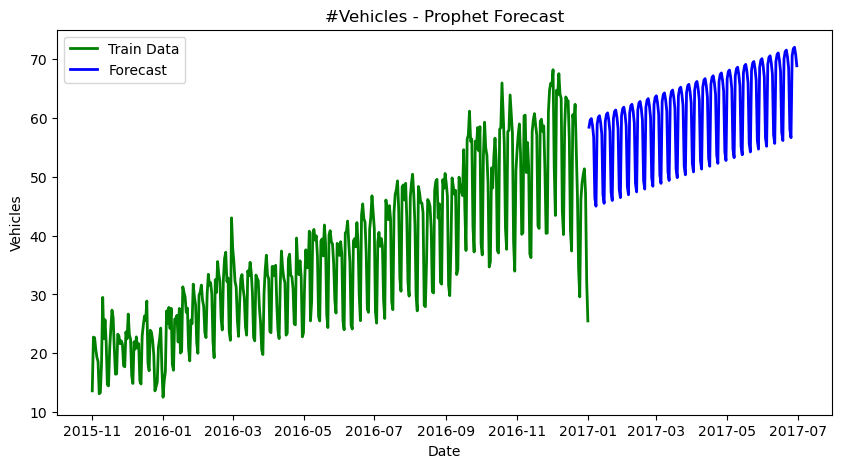

In [81]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_train_prophet['ds'], df_train_prophet['y'], label='Train Data', color='green', linewidth=2)
ax.plot(df_test_fcst['ds'], df_test_fcst['yhat'], label='Forecast', color='blue', linewidth=2)

ax.set_title('#Vehicles - Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Vehicles')
ax.legend(loc='upper left')
plt.show()

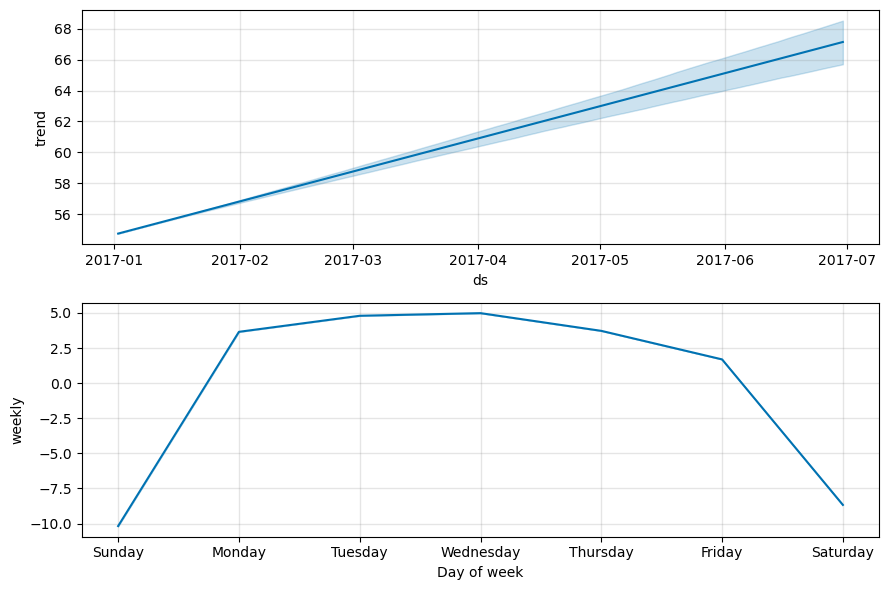

In [82]:
fig = model.plot_components(df_test_fcst)
plt.show()

##### Compare Forecast to Actuals

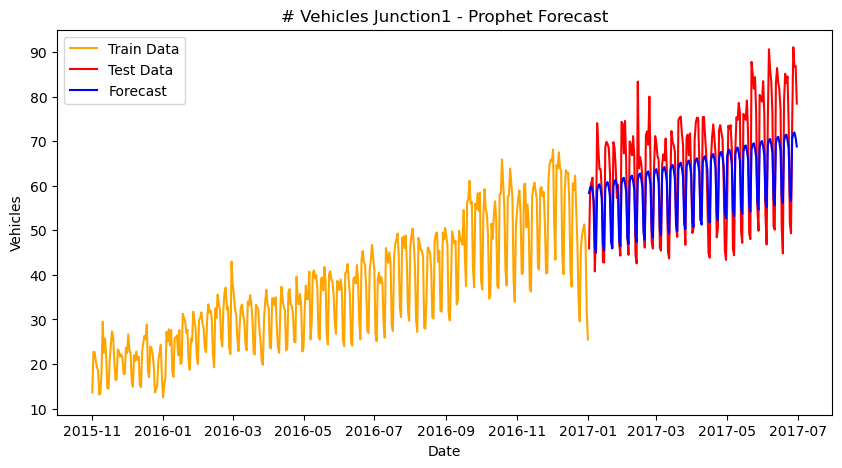

In [83]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_train.index, df_train['Vehicles'], color='orange', label='Train Data', linestyle='-')
ax.plot(df_test.index, df_test['Vehicles'], color='red', label='Test Data', linestyle='-')
ax.plot(df_test_fcst['ds'], df_test_fcst['yhat'], color='blue', label='Forecast', linestyle='-')
ax.legend()
ax.set_title('# Vehicles Junction1 - Prophet Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Vehicles')
plt.show()

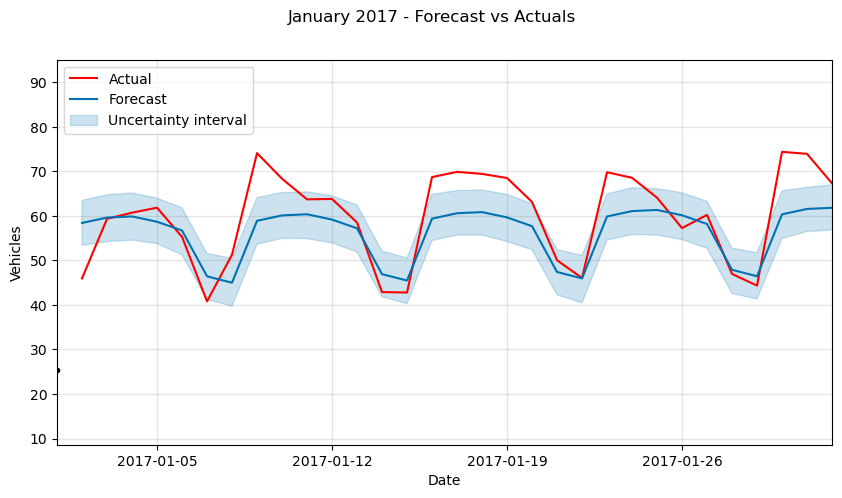

In [84]:
start_date = datetime.strptime('01-01-2017', '%m-%d-%Y')
end_date = datetime.strptime('02-01-2017', '%m-%d-%Y')

plt.figure(figsize=(10, 5))

# Plotting the actual values
plt.plot(df_test.index, df_test['Vehicles'], 'r-', label="Actual")  # 'r-' for red line plot

# Plotting the forecast
model.plot(df_test_fcst, ax=plt.gca())  # Ensure forecast is on the same plot

# Setting the x-axis bounds
plt.xlim([start_date, end_date])

# Filtering legend entries to remove 'Observed data points'
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l != 'Observed data points']
filtered_handles, filtered_labels = zip(*filtered_handles_labels)
plt.legend(filtered_handles, filtered_labels, loc='upper left')

# Setting the labels and title
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.suptitle('January 2017 - Forecast vs Actuals')

# Display the plot
plt.show()

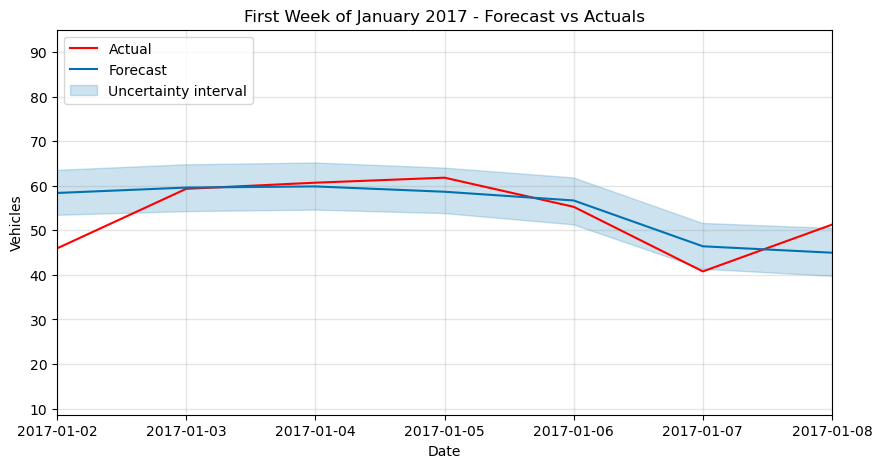

In [85]:
start_date = datetime.strptime('01-02-2017', '%m-%d-%Y')
end_date = datetime.strptime('01-08-2017', '%m-%d-%Y')

plt.figure(figsize=(10, 5))

# Plotting actual values
plt.plot(df_test.index, df_test['Vehicles'], 'r-', label="Actual")  # 'r-' means red line

# Plotting the forecast
model.plot(df_test_fcst, ax=plt.gca())  # Plotting forecast using the model

# Setting the bounds for the x-axis
plt.xlim([start_date, end_date])

# Adding title and labels
plt.title('First Week of January 2017 - Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Vehicles')

# Handling the legend
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l != 'Observed data points']
filtered_handles, filtered_labels = zip(*filtered_handles_labels)
plt.legend(filtered_handles, filtered_labels, loc='upper left')

# Display the plot
plt.show()

##### Evaluate the model

In [114]:
mae = mean_absolute_error(y_true=df_test['Vehicles'],
                   y_pred=df_test_fcst['yhat'])
mape = mean_absolute_percentage_error(y_true=df_test['Vehicles'],
                   y_pred=df_test_fcst['yhat'])*100
rmse = np.sqrt(mean_squared_error(y_true=df_test['Vehicles'],
                   y_pred=df_test_fcst['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'Prophet': [mae, f'{mape:.2f}%', rmse],
})

print(performance.set_index('Metrics'))

          Prophet
Metrics          
MAE      6.854436
MAPE       10.17%
RMSE     8.210473


##### Adding Holidays

We will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

In [87]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=df_daily.index.min(),
                        end=df_daily.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [88]:
holiday_df.head()

,ds,holiday
0,2015-11-11,Veterans Day
1,2015-11-26,Thanksgiving Day
2,2015-12-25,Christmas Day
3,2016-01-01,New Year's Day
4,2016-01-18,"Birthday of Martin Luther King, Jr."


In [89]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(df_train_prophet)

13:17:16 - cmdstanpy - INFO - Chain [1] start processing
13:17:16 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 46.9 ms
Wall time: 260 ms


In [92]:
df_test_fcst_with_hols = model_with_holidays.predict(df=df_test_prophet)

In [120]:
mae = mean_absolute_error(y_true=df_test,
                   y_pred=df_test_fcst['yhat'])
mape = mean_absolute_percentage_error(y_true=df_test,
                   y_pred=df_test_fcst['yhat'])*100
rmse = np.sqrt(mean_squared_error(y_true=df_test,
                   y_pred=df_test_fcst['yhat']))

mae_with_hols = mean_absolute_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat'])
mape_with_hols = mean_absolute_percentage_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat'])*100
rmse_with_hols = np.sqrt(mean_squared_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'Prophet': [mae, f'{mape:.2f}%', rmse],
    'Prophet(holidays)': [mae_with_hols, f'{mape_with_hols:.2f}%', rmse_with_hols]
})

print(performance.set_index('Metrics'))

          Prophet Prophet(holidays)
Metrics                            
MAE      6.854436          6.538943
MAPE       10.17%             9.75%
RMSE     8.210473          7.882583


The model with holidays is slightly better at capturing patterns in the data.

##### Predict into the Future

In [94]:
%%time
df_prophet = df_daily.reset_index() \
    .rename(columns={'DateTime':'ds',
                     'Vehicles':'y'})
model_with_holidays = Prophet(holidays=holiday_df)
model_fulldf = model_with_holidays.fit(df_prophet)

13:18:03 - cmdstanpy - INFO - Chain [1] start processing
13:18:03 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 46.9 ms
Wall time: 291 ms


In [95]:
# Generates future dates starting from the last date in df.
future_data = model_fulldf.make_future_dataframe(
                    periods=365*1, 
#                     freq='h', 
                    include_history=False)
next_forecast = model_fulldf.predict(future_data)
next_forecast[['ds','yhat']].head()

,ds,yhat
0,2017-07-01,62.264789
1,2017-07-02,60.763868
2,2017-07-03,78.216630
3,2017-07-04,79.716080
4,2017-07-05,79.368252


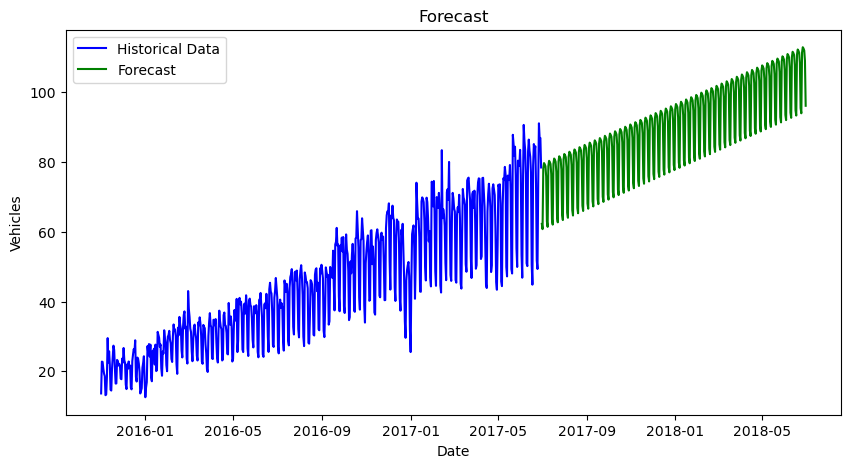

In [96]:
plt.figure(figsize=(10, 5))
plt.plot(df_daily.index, df_daily['Vehicles'], label='Historical Data', color='blue')
plt.plot(next_forecast['ds'], next_forecast['yhat'], label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.title('Forecast')
plt.legend()
plt.show()

## SARIMA Model

In [97]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.api as smt
from tabulate import tabulate
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from itertools import product 
from tqdm.notebook import tqdm

##### Check stationary

In [98]:
df_diff = df_daily.diff().dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                         |
|---------------|-------------------------------|
| ADF Statistic | -8.922561057783               |
| P-value       | 1.0316569467423075e-14        |
| Conclusion    | The time series is stationary |


##### Define orders

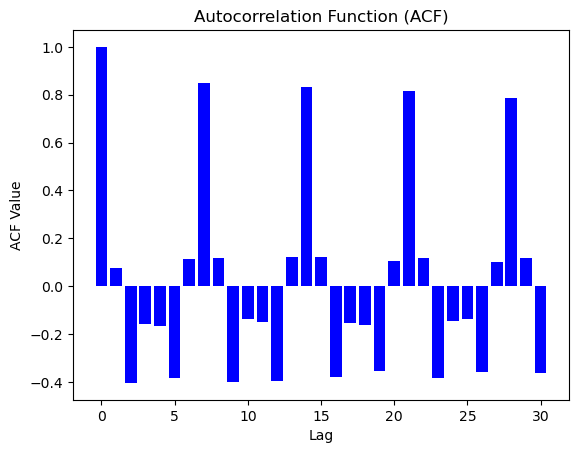

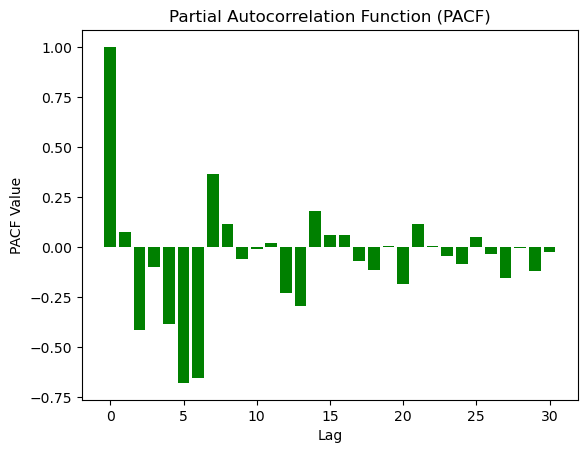

In [99]:
max_lags = 30  # Maximum allowable lags

acf_vals = acf(df_diff, nlags=max_lags)
plt.bar(range(len(acf_vals)), acf_vals, color='blue')
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.show()

pacf_vals = pacf(df_diff, nlags=max_lags)
plt.bar(range(len(pacf_vals)), pacf_vals, color='green')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF Value')
plt.show()

In [100]:
# setting initial values and some bounds for them
ps = range(0, 3)
d=1 
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(0, 3)
s = 7 # season length 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

81

In [101]:
def optimizeSARIMA(parameters_list, d, D, s, df):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
        df - the DataFrame containing the time series data
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [102]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s, df_train)

  0%|          | 0/81 [00:00<?, ?it/s]

CPU times: total: 52.8 s
Wall time: 36 s


In [103]:
result_table.head()

,parameters,aic
0,"(1, 2, 0, 1)",2075.661682
1,"(1, 1, 0, 2)",2076.425978
2,"(1, 2, 0, 2)",2076.603861
3,"(1, 1, 1, 1)",2076.839017
4,"(1, 2, 1, 1)",2076.848487


##### Fit the model

In [104]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Vehicles   No. Observations:                  428
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -1032.831
Date:                             Tue, 03 Sep 2024   AIC                           2075.662
Time:                                     13:18:40   BIC                           2095.863
Sample:                                 11-01-2015   HQIC                          2083.646
                                      - 01-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8768      0.043     20.216      0.000       0.792       0.962
ma.L1         -1.3656      

##### Residual Analysis

In [105]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

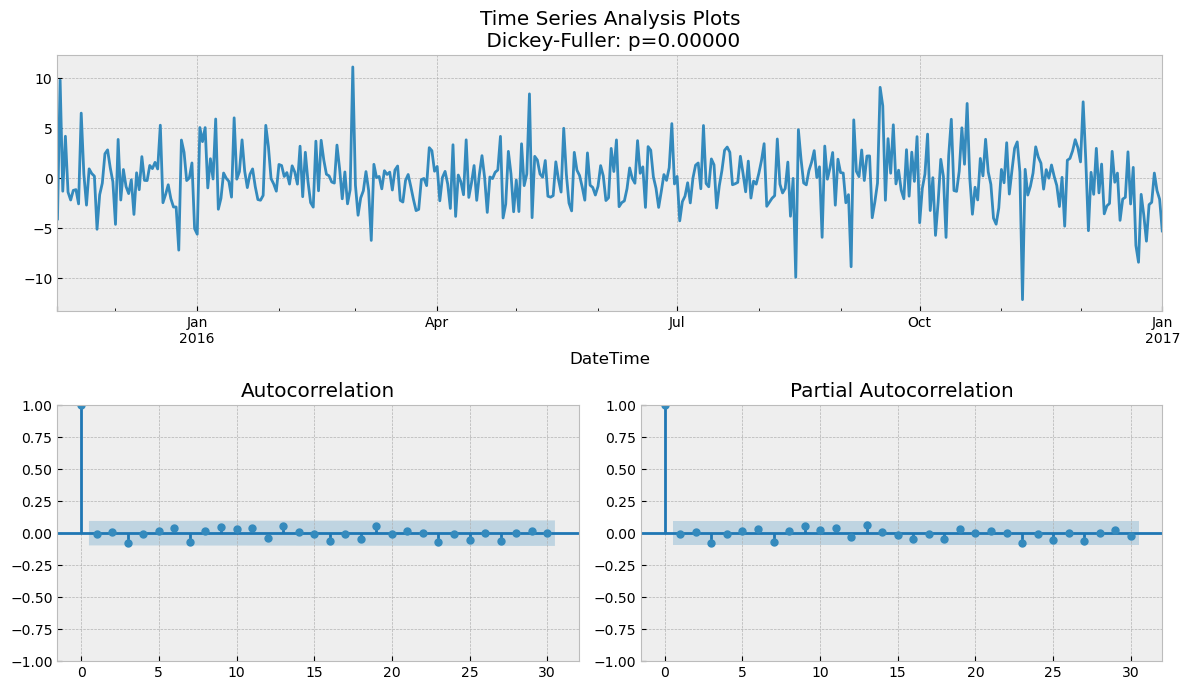

In [106]:
tsplot(best_model.resid[7+1:], lags=30)

##### Predictions

In [107]:
forecast = best_model.get_prediction(start=df_test.index[0], end=df_test.index[-1], dynamic=False)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

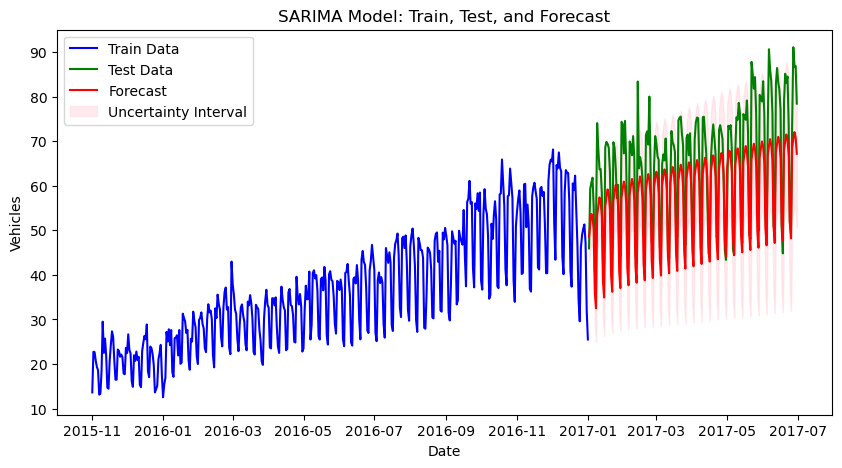

In [108]:
plt.figure(figsize=(10, 5))

# Plotting the training data
plt.plot(df_train.index, df_train, label='Train Data', color='blue')

# Plotting the actual test data
plt.plot(df_test.index, df_test, label='Test Data', color='green')

# Plotting the forecasted data
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')

# Plotting the confidence intervals
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Uncertainty Interval')

# Final plot adjustments
plt.title('SARIMA Model: Train, Test, and Forecast')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

In [119]:
#### Compare Prophet and SARIMA
mae_with_hols = mean_absolute_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat'])
mape_with_hols = mean_absolute_percentage_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat'])*100
rmse_with_hols = np.sqrt(mean_squared_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat']))

mae_sarima = mean_absolute_error(df_test, forecast_mean)
mape_sarima = mean_absolute_percentage_error(df_test, forecast_mean) * 100
rmse_sarima = np.sqrt(mean_squared_error(df_test, forecast_mean))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'Prophet(holidays)': [mae_with_hols, f'{mape_with_hols:.2f}%', rmse_with_hols],
    'SARIMA': [mae_sarima, f'{mape_sarima:.2f}%', rmse_sarima]
})

print(performance.set_index('Metrics'))

        Prophet(holidays)    SARIMA
Metrics                            
MAE              6.538943  7.942679
MAPE                9.75%    11.65%
RMSE             7.882583  9.326558


Prophet outperforms SARIMA in forecasting traffic data due to its superior ability to capture trends, seasonality, and holiday effects, leading to lower error metrics. This suggests Prophet is better suited for the complexities of this dataset.

## SARIMAX Model

In [110]:
from holidays import US
us_holidays = US(years=[2015, 2016, 2017])

# Create copies of the original DataFrames before adding the 'isholiday' column
df_train_holidays = df_train.copy()
df_test_holidays = df_test.copy()

# Add the 'isholiday' column to the copied DataFrames
df_train_holidays['isholiday'] = df_train_holidays.index.normalize().isin(us_holidays).astype(int)
df_test_holidays['isholiday'] = df_test_holidays.index.normalize().isin(us_holidays).astype(int)

# Create exogenous matrices for holidays
exog_train = df_train_holidays[['isholiday']]
exog_test = df_test_holidays[['isholiday']]

# Fit the SARIMAX model with holidays as exogenous variables
model_holds = SARIMAX(df_train_holidays['Vehicles'], 
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                exog=exog_train)
best_model_holds = model_holds.fit()

# Make predictions using the test exogenous variables
forecast_holds = best_model_holds.get_prediction(start=df_test.index[0], end=df_test.index[-1], exog=exog_test)
forecast_mean_holds = forecast_holds.predicted_mean
forecast_conf_int = forecast.conf_int()

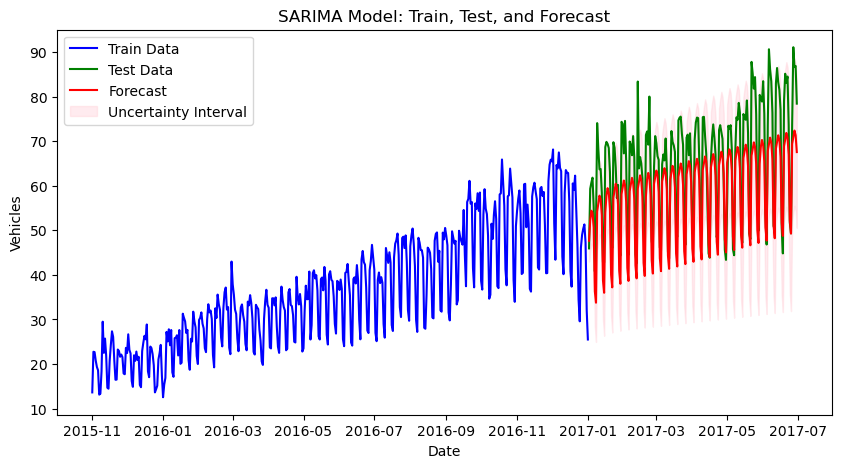

In [111]:
plt.figure(figsize=(10, 5))

# Plotting the training data
plt.plot(df_train.index, df_train, label='Train Data', color='blue')

# Plotting the actual test data
plt.plot(df_test.index, df_test, label='Test Data', color='green')

# Plotting the forecasted data
plt.plot(forecast_mean_holds.index, forecast_mean_holds, label='Forecast', color='red')

# Plotting the confidence intervals
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Uncertainty Interval')

# Final plot adjustments
plt.title('SARIMA Model: Train, Test, and Forecast')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

## Final Evaluation : Prophet - SARIMA - SARIMAX

In [118]:
mae = mean_absolute_error(y_true=df_test,
                   y_pred=df_test_fcst['yhat'])
mape = mean_absolute_percentage_error(y_true=df_test,
                   y_pred=df_test_fcst['yhat'])*100
rmse = np.sqrt(mean_squared_error(y_true=df_test,
                   y_pred=df_test_fcst['yhat']))

mae_with_hols = mean_absolute_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat'])
mape_with_hols = mean_absolute_percentage_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat'])*100
rmse_with_hols = np.sqrt(mean_squared_error(y_true=df_test,
                   y_pred=df_test_fcst_with_hols['yhat']))

mae_sarima = mean_absolute_error(df_test, forecast_mean)
mape_sarima = mean_absolute_percentage_error(df_test, forecast_mean) * 100
rmse_sarima = np.sqrt(mean_squared_error(df_test, forecast_mean))

mae_sarimax = mean_absolute_error(df_test, forecast_mean_holds)
mape_sarimax = mean_absolute_percentage_error(df_test, forecast_mean_holds) * 100
rmse_sarimax = np.sqrt(mean_squared_error(df_test, forecast_mean_holds))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'Prophet': [mae, f'{mape:.2f}%', rmse],
    'Prophet(holidays)': [mae_with_hols, f'{mape_with_hols:.2f}%', rmse_with_hols],
    'SARIMA': [mae_sarima, f'{mape_sarima:.2f}%', rmse_sarima],
    'SARIMAX(holidays)': [mae_sarimax, f'{mape_sarimax:.2f}%', rmse_sarimax]
})

print(performance.set_index('Metrics'))

          Prophet Prophet(holidays)    SARIMA SARIMAX(holidays)
Metrics                                                        
MAE      6.854436          6.538943  7.942679           7.56856
MAPE       10.17%             9.75%    11.65%            11.06%
RMSE     8.210473          7.882583  9.326558          8.970963


The Prophet model with holidays provides the most accurate forecasts for this traffic dataset. Including holidays significantly improves the model's performance, especially in Prophet. While SARIMAX also benefits from including holidays, it does not outperform the Prophet models. This suggests that Prophet’s approach to handling holidays and trends is particularly well-suited to this data.